In [1]:
!pip install jupyter pandas sentence_transformers "qdrant_client~=1.1.1" pyarrow fastembed datasets


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
from datasets import load_dataset

ds = load_dataset("Porameht/product-img-rating")

print(len(ds['train']))

Generating train split:   0%|          | 0/113660 [00:00<?, ? examples/s]

113660


In [4]:
import pandas as pd

df = ds['train'].to_pandas()

df.sample(n=5).T

,93946,81348,105834,63981,40848
title,<New Meson IO> Philips โคมไฟดาวน์ไลท์ ฟิลิปส์ ...,Schneider Electric ตู้คอนซูเมอร์ยูนิตฝาทึบ 18 ...,TOA สีภายนอก+ภายใน สีฟ้า 1L,[ฟรีติดตั้ง] มอเตอร์ประตูรั้วรีโมท Somfy Elixo...,Garmin Instinct 2 / 2S Series [รับประกันศูนย์ไทย]
name,<New Meson IO> Philips โคมไฟดาวน์ไลท์ ฟิลิปส์ ...,Schneider Electric ตู้คอนซูเมอร์ยูนิตฝาทึบ 18 ...,TOA สีภายนอก+ภายใน สีฟ้า 1L 5240 1 ลิตร,[ฟรีติดตั้ง] มอเตอร์ประตูรั้วรีโมท Somfy Elixo...,Garmin Instinct 2 / 2S Series [รับประกันศูนย์ไ...
product_url,/p/โคมไฟฝังฝ้า/New-Meson-IO-Philips-โคมไฟดาวน์...,/p/ตู้คอนซูเมอร์ยูนิต/Schneider-Electric-ตู้คอ...,/p/สีทาภายนอก/TOA-สีภายนอกภายใน-สีฟ้า-1L-5240-...,/p/กลอนประตู/ฟรีติดตั้ง-มอเตอร์ประตูรั้วรีโมท-...,/p/อุปกรณ์ออกกำลังกาย/Garmin-Instinct-2--2S-Se...
price,159.0,8199.780273,289.100006,25800.0,13690.0
original_price,159.0,16078.0,295.0,28900.0,13690.0
unit,ชิ้น,ชิ้น,แกลลอน,ชิ้น,ชิ้น
overall_rating,5.0,0.0,0.0,0.0,0.0
rating_count,2,0,0,0,0
image_url,https://nocnoc.com/assets-static/assets/portal...,https://nocnoc.com/assets-static/assets/portal...,https://nocnoc.com/assets-static/assets/portal...,https://nocnoc.com/assets-static/assets/portal...,https://nocnoc.com/assets-static/assets/portal...
image,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [5]:
df.shape

(113660, 10)

In [6]:
df.iloc[0]["image_url"]

'https://nocnoc.com/assets-static/assets/portal-assets/1133671/product/images/27372/180005854-107__288x288.jpg'

In [7]:
!rm -rf data queries

In [8]:
!mkdir data
!mkdir data/images
!mkdir queries

In [10]:
import os
import uuid
import logging
from typing import Optional, Union, Dict
from PIL import Image
import io
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def process_image_bytes(image_data: Dict[str, bytes]) -> Optional[str]:
    target_path = None
    try:
        jpg_basename = f"{uuid.uuid4()}.jpg"
        target_path = f"./data/images/{jpg_basename}"
        
        image_bytes = image_data.get('bytes')
        if not image_bytes:
            raise ValueError("No 'bytes' key found in the image data dictionary")
        
        with Image.open(io.BytesIO(image_bytes)) as img:
            img = img.convert('RGB')
            img.save(target_path, 'JPEG')
    except (IOError, ValueError) as e:
        logging.error(f"Error processing the image: {e}")
        return None
    
    return target_path

def process_dataframe(df, num_workers=10):
    os.makedirs("./data/images", exist_ok=True)
    
    def process_row(row):
        local_image = process_image_bytes(row['image'])
        return local_image
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_row, row) for _, row in df.iterrows()]
        
        results = []
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing images"):
            results.append(future.result())
    
    df['LocalImage'] = results
    
    df_cleaned = df.dropna(subset=['LocalImage'])
    
    logging.info(f"Processed {len(df)} images. {len(df_cleaned)} successful, {len(df) - len(df_cleaned)} failed.")
    
    return df_cleaned

dataset_df = process_dataframe(df)

print(dataset_df.sample(n=5).T)

print(f"Total images processed: {len(df)}")
print(f"Successful processing: {len(dataset_df)}")
print(f"Failed processing: {len(df) - len(dataset_df)}")

Processing images: 100%|██████████| 113660/113660 [00:38<00:00, 2918.20it/s]
2024-07-30 14:44:15,263 - INFO - Processed 113660 images. 113660 successful, 0 failed.


                                                            33629  \
title           Dining Vaisselle - แก้วไวน์ขอบทอง Chateau Crys...   
name            Dining Vaisselle - แก้วไวน์ขอบทอง Chateau Crys...   
product_url     /p/แก้วน้ำ/Dining-Vaisselle---แก้วไวน์ขอบทอง-C...   
price                                                       350.0   
original_price                                              480.0   
unit                                                         ชิ้น   
overall_rating                                                0.0   
rating_count                                                    0   
image_url       https://nocnoc.com/assets-static/assets/portal...   
image           {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...   
LocalImage      ./data/images/0fab8fed-74a2-45f3-baf9-7298dd0d...   

                                                            23955  \
title           TOTO อ่างล้างหน้า แบบฝังบนเคาน์เตอร์ WHITE 482...   
name            TOTO อ่างล้างหน้า

In [11]:
dataset_df.sample(n=5).T

,105777,55264,106363,27508,32584
title,TOA สี 4 SEASONS สีภายนอกภายใน กึ่งเงา ด้าน สี...,VAVO ยูเนี่ยนวาล์วพีวีซี 2นิ้ว Union ball Valv...,Beger คูลออลพลัส สีส้มอิฐ ฟิล์มด้าน ภายนอกภายใ...,VRH PR. ตะแกรงหัวน้ำฝนทรงสี่เหลี่ยม รุ่น FUVHU...,Zojirushi กระติกน้ำสุญญากาศเก็บความร้อน/ความเย...
name,TOA สี 4 SEASONS สีภายนอกภายใน กึ่งเงา ด้าน สี...,VAVO ยูเนี่ยนวาล์วพีวีซี 2นิ้ว Union ball Valv...,Beger คูลออลพลัส สีส้มอิฐ ฟิล์มด้าน ภายนอกภายใ...,VRH PR. ตะแกรงหัวน้ำฝนทรงสี่เหลี่ยม รุ่น FUVHU...,Zojirushi กระติกน้ำสุญญากาศเก็บความร้อน/ความเย...
product_url,/p/สีทาภายนอก/TOA-สี-4-SEASONS-สีภายนอกภายใน-ก...,/p/เครื่องมือและอุปกรณ์ทำสวน/VAVO-ยูเนี่ยนวาล์...,/p/สีทาภายนอก/Beger-คูลออลพลัส-สีส้มอิฐ-ฟิล์มด...,/p/ท่อน้ำทิ้ง/VRH-PR-ตะแกรงหัวน้ำฝนทรงสี่เหลี่...,/p/แก้วน้ำ/Zojirushi-กระติกน้ำสุญญากาศเก็บความ...
price,660.52002,563.0,182.279999,459.0,840.0
original_price,674.0,648.0,186.0,740.0,1200.0
unit,แกลลอน,ชิ้น,แกลลอน,ชิ้น,ชิ้น
overall_rating,0.0,0.0,0.0,5.0,0.0
rating_count,0,0,0,1,0
image_url,https://nocnoc.com/assets-static/assets/portal...,https://nocnoc.com/assets-static/assets/portal...,https://nocnoc.com/assets-static/assets/portal...,https://nocnoc.com/assets-static/assets/portal...,https://nocnoc.com/assets-static/assets/portal...
image,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


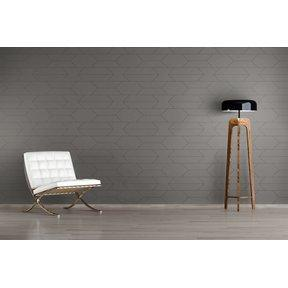

In [12]:
from PIL import Image

image = Image.open(dataset_df.iloc[0]["LocalImage"])
image

In [13]:
from fastembed import ImageEmbedding

model = ImageEmbedding(model_name="Qdrant/clip-ViT-B-32-vision")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/780 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/352M [00:00<?, ?B/s]

In [14]:
image_embedding = next(model.embed([dataset_df.iloc[0]["LocalImage"]]))
image_embedding.shape

(512,)

In [15]:
image_embedding

array([-1.45532470e-02,  1.33148134e-02,  2.83111110e-02,  1.92665984e-03,
       -1.39562348e-02,  2.46274266e-02,  1.45158572e-02, -2.71376912e-02,
       -3.41504253e-02,  1.12556713e-02,  2.30576727e-03,  3.35608535e-02,
        4.71526384e-02, -1.98533460e-02,  1.80345792e-02,  1.41537478e-02,
       -5.69896959e-03,  3.69838662e-02, -1.41668860e-02,  2.30765976e-02,
        7.91280568e-02, -3.97773497e-02,  3.64915468e-02,  1.60328262e-02,
        1.77601457e-03,  7.61178927e-03,  3.62606235e-02, -2.75586899e-02,
        1.39203132e-03,  2.12446228e-02,  4.63017486e-02,  3.26902838e-03,
       -5.85669698e-03, -3.42214666e-02, -5.48813194e-02, -3.11529078e-03,
       -3.31429392e-02,  4.22888855e-03,  1.56594925e-02,  7.42318779e-02,
       -2.30946206e-02, -2.28589140e-02,  3.82065736e-02, -4.13512290e-02,
        5.17240912e-03, -2.11276218e-01, -2.31226310e-02,  6.09305827e-03,
        2.78292838e-02,  2.34445352e-02,  2.10067853e-02, -3.35407853e-02,
        3.17387953e-02,  

In [16]:
from typing import List

def calculate_embedding(image_path: str) -> Optional[List[float]]:
    try:
        return next(model.embed([image_path])).tolist()
    except:
        return None

In [17]:
# Again, our helper function returns None in case of any error, such as
# unsupported image format. We need to remove those entries.
# dataset_df["Embedding"] = dataset_df["LocalImage"].map(calculate_embedding)
# dataset_df["Embedding"] = dataset_df["Embedding"].replace({None: np.nan})
# dataset_df = dataset_df.dropna(subset=["Embedding"])
# dataset_df.sample(n=5).T

In [17]:
import numpy as np
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial

def calculate_embedding_wrapper(path):
    try:
        return calculate_embedding(path)
    except Exception:
        return None

def calculate_embeddings_batch(paths, batch_size=1000):
    with ProcessPoolExecutor(max_workers=32) as executor:
        return list(executor.map(calculate_embedding_wrapper, paths, chunksize=batch_size))

def process_dataframe(df, batch_size=1000):
    total_batches = len(df) // batch_size + (1 if len(df) % batch_size else 0)
    all_embeddings = []
    
    for i in range(total_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(df))
        batch_paths = df['LocalImage'].iloc[start_idx:end_idx].tolist()
        
        batch_embeddings = calculate_embeddings_batch(batch_paths, batch_size=batch_size//32)
        all_embeddings.extend(batch_embeddings)
        
        print(f"Processed batch {i+1}/{total_batches}")
    
    return all_embeddings

embeddings = process_dataframe(dataset_df, batch_size=10000)

valid_mask = [embedding is not None for embedding in embeddings]

dataset_df = dataset_df[valid_mask].copy()
dataset_df['Embedding'] = [embedding for embedding in embeddings if embedding is not None]

sample_df = dataset_df.sample(n=5).T

Processed batch 1/12
Processed batch 2/12
Processed batch 3/12
Processed batch 4/12
Processed batch 5/12
Processed batch 6/12
Processed batch 7/12
Processed batch 8/12
Processed batch 9/12
Processed batch 10/12
Processed batch 11/12
Processed batch 12/12


In [18]:
dataset_df.to_parquet("./data/product-image-embeddings.parquet")

In [3]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("Porameht/product-image-114k-embedding")

dataset_df = pd.DataFrame(ds['train'])

dataset_df.to_parquet('product_image_114k_embedding.parquet', index=False)

Generating train split:   0%|          | 0/113660 [00:00<?, ? examples/s]

บันทึกข้อมูลเป็นไฟล์ Parquet เรียบร้อยแล้ว
                                               title  \
0               Namiko โซฟาทรงฟักทอง pumkin  - คละสี   
1               Namiko โซฟาทรงฟักทอง pumkin  - คละสี   
2               Namiko โซฟาทรงฟักทอง pumkin  - คละสี   
3    Namiko โซฟาเอนนั่งขนาดเล็ก 1.2m Cloudy  - คละสี   
4  MONSTER STEEL เก้าอี้บาร์ MONSTER STEEL รุ่น C...   

                                                name  \
0  Namiko โซฟาทรงฟักทอง pumkin  - คละสี White + ท...   
1  Namiko โซฟาทรงฟักทอง pumkin  - คละสี Brown + ท...   
2         Namiko โซฟาทรงฟักทอง pumkin  - คละสี Brown   
3  Namiko โซฟาเอนนั่งขนาดเล็ก 1.2m Cloudy  - คละส...   
4  MONSTER STEEL เก้าอี้บาร์ MONSTER STEEL รุ่น C...   

                                         product_url   price  original_price  \
0  /p/โซฟา/Namiko-โซฟาทรงฟักทอง-pumkin---คละสี-Wh...  8290.0          9990.0   
1  /p/โซฟา/Namiko-โซฟาทรงฟักทอง-pumkin---คละสี-Br...  8290.0          9990.0   
2  /p/โซฟา/Namiko-โซฟาทรงฟักทอง-pumkin---คล

In [19]:
from datasets import Dataset

dataset_name = "Porameht/product-image-114k-embedding"
parquet_file = "./data/product-image-embeddings.parquet"
dataset = Dataset.from_parquet(parquet_file)

dataset.push_to_hub(dataset_name)

Generating train split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/5 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/228 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/228 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/228 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/228 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/228 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Porameht/product-image-114k-embedding/commit/6f4453f72f82bb624e29aaeea1ee9631d1addec7', commit_message='Upload dataset', commit_description='', oid='6f4453f72f82bb624e29aaeea1ee9631d1addec7', pr_url=None, pr_revision=None, pr_num=None)

In [13]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest

try:
    client = QdrantClient(
        url="",
        api_key="",
        prefer_grpc=True,
    )
    collections = client.get_collections()
except Exception:
    client = QdrantClient(":memory:")
    collections = client.get_collections()

collections

CollectionsResponse(collections=[CollectionDescription(name='amazon'), CollectionDescription(name='product_nc-1'), CollectionDescription(name='text-demo')])

In [14]:
client.recreate_collection(
    collection_name="nocnoc",
    vectors_config=rest.VectorParams(
        size=512,
        distance=rest.Distance.COSINE,
    )
)

True

In [15]:
import uuid

def generate_random_id():
    return str(uuid.uuid4())

payloads = dataset_df[["title", "name", "product_url", "price", "original_price", "unit", "overall_rating", "rating_count", "image_url"]] \
    .fillna("Unknown") \
    .rename(columns={
        "name": "document"
    })

payloads['ID'] = [generate_random_id() for _ in range(len(payloads))]

payloads = payloads.to_dict("records")

print(payloads[0])

{'title': 'Namiko โซฟาทรงฟักทอง pumkin  - คละสี', 'document': 'Namiko โซฟาทรงฟักทอง pumkin  - คละสี White + ที่พักขา', 'product_url': '/p/โซฟา/Namiko-โซฟาทรงฟักทอง-pumkin---คละสี-White--ที่พักขา/12051628', 'price': 8290.0, 'original_price': 9990.0, 'unit': 'ชิ้น', 'overall_rating': 0.0, 'rating_count': 0, 'image_url': 'https://nocnoc.com/assets-static/assets/portal-assets/1133671/product/images/27372/180005854-107__288x288.jpg', 'ID': 'd3682c5f-0def-45a0-9879-c18805df320b'}


In [16]:
import uuid

client.upload_collection(
    collection_name="nocnoc",
    vectors=list(map(list, dataset_df["Embedding"].tolist())),
    payload=payloads,
    ids=[uuid.uuid4().hex for _ in payloads],
)

In [17]:
client.count("nocnoc")

CountResult(count=113660)

In [18]:
from io import BytesIO

import base64

def pillow_image_to_base64(image: Image) -> str:
    """
    Convert a Pillow image to a base64 encoded string that can be used as an image
    source in HTML.
    :param image:
    :return:
    """
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/jpeg;base64,{img_str}"

NameError: name 'Image' is not defined

,,,,,,,,,

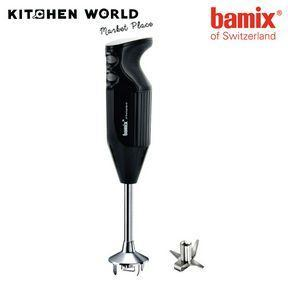
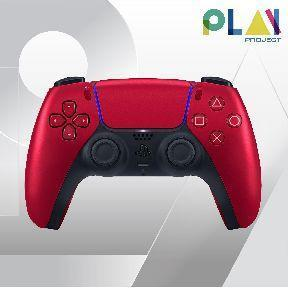
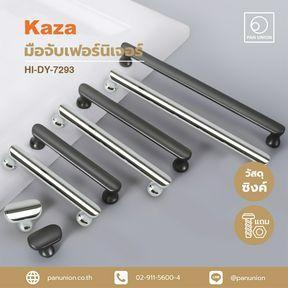
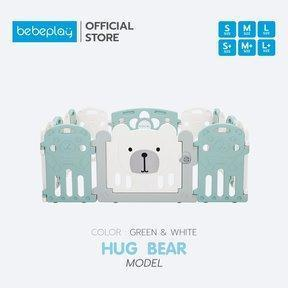
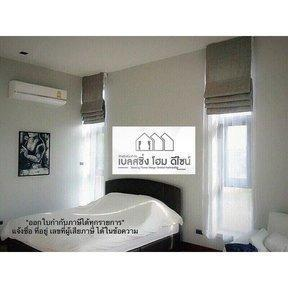
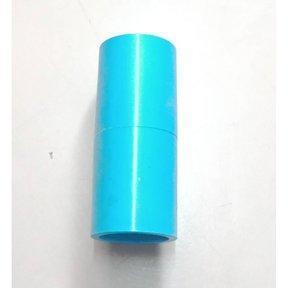
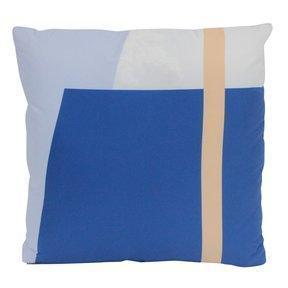
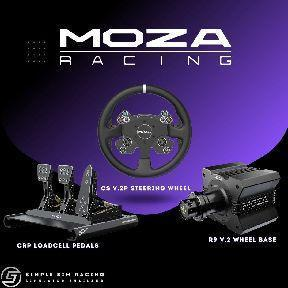
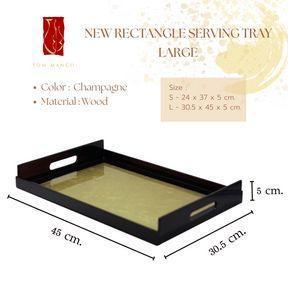
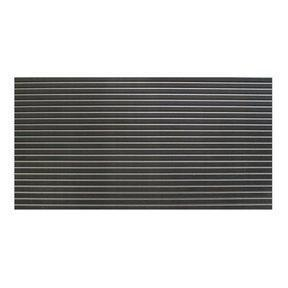

Selected image paths:
./data/images/33b64849-ff1d-44cf-bf9d-be9f94febed0.jpg
./data/images/cf5166f5-4064-470f-af9e-de2eeac50a4d.jpg
./data/images/17f581a0-dd97-43ef-b1c4-1987b72cd8af.jpg
./data/images/7d7be9df-9e0a-4e5d-8200-d597bc9ce795.jpg
./data/images/e8484db0-d158-4edf-9a39-2f048f373301.jpg
./data/images/6c1332cc-e24d-415a-abf0-8b7ddbd21923.jpg
./data/images/89d8b8ee-5675-488b-92dc-ee830fa8ba44.jpg
./data/images/3431b776-3312-4de6-9e2d-9e8776966a44.jpg
./data/images/a66915fd-e154-4450-9da8-1d1ac881239d.jpg
./data/images/6ae3a3ba-41c2-4ac6-9e9d-963ba183f90b.jpg


In [19]:
from IPython.display import display, HTML
import glob
import random
from PIL import Image
import base64
import io

def pillow_image_to_base64(image):
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode()

def display_random_images(image_folder, num_images=5):
    # Get all image paths
    all_image_paths = list(glob.glob(f"{image_folder}/*.jpg"))
    
    # Randomly select 'num_images' paths
    selected_paths = random.sample(all_image_paths, min(num_images, len(all_image_paths)))
    
    # Generate HTML for selected images
    images_html = "".join(
        f"<td><img src='data:image/jpeg;base64,{pillow_image_to_base64(Image.open(path))}' width=150></td>"
        for path in selected_paths
    )
    
    # Display images
    display(HTML(f"<table><tr>{images_html}</tr></table>"))
    
    return selected_paths

# Usage
selected_images = display_random_images("./data/images", num_images=10)
print("Selected image paths:")
for path in selected_images:
    print(path)

In [20]:
for query_image_path in selected_images:
    query_embedding = next(model.embed(query_image_path)).tolist()

    # print(query_embedding)
    results = client.search(
      collection_name="nocnoc",
      query_vector=query_embedding,
      limit=3  # Adjust the number of results as needed
    )


    output_images = [
        # pillow_image_to_base64(Image.open(query_image_path)),
    ]
    for result in results:
        output_images.append(result.payload["ImageUrl"])

    images_html = "".join(
        f"<td><img src='{path}' width=150></td>"
        for path in output_images
    )
    display(HTML(f"<table><tr>{images_html}</tr></table>"))

NameError: name 'model' is not defined